# Tensorflow

Primeiro precisamos importar as dependências e realizar os ajustes necessários nos dados a fim de deixá-los prontos para o processamento.

In [133]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train/255.0
x_test = x_test/255.0

## Utilidades

In [250]:
def get_metrics(x_test, y_test, model):
  test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
  y_pred = model.predict(x_test)
  y_pred_labels = tf.argmax(y_pred, axis=1)

  precisions = precision_score(y_test, y_pred_labels, average=None)
  recalls = recall_score(y_test, y_pred_labels, average=None)
  f1_scores = f1_score(y_test, y_pred_labels, average=None)

  return {
      'precisions': precisions,
      'recalls': recalls,
      'f1_scores': f1_scores,
      'y_pred_labels': y_pred_labels,
      'macro': {
          'precision': precision_score(y_test, y_pred_labels, average='macro'),
          'recall': recall_score(y_test, y_pred_labels, average='macro'),
          'accuracy': test_accuracy,
          'loss': test_loss,
      }
  }

In [254]:
def plot_accuracy_per_label(y_true, y_pred, output_size=10, accuracy=0, precision=0, recall=0):
    accuracies = np.zeros((output_size, output_size))
    for i in range(output_size):
        for j in range(output_size):
            true_positive = np.sum((y_true == i) & (y_pred == j))
            total_true = np.sum(y_true == i)
            accuracy = true_positive / total_true if total_true > 0 else 0
            accuracies[i, j] = accuracy

    subtitle = f'Accuracy: {accuracy:.2f} Precision: {precision:.2f} Recall: {recall:.2f}'
    plt.imshow(accuracies, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Accuracy Heatmap')
    plt.xticks(np.arange(output_size))
    plt.yticks(np.arange(output_size))
    plt.gca().set_facecolor('white')
    plt.grid(color='lightblue', linestyle='-', linewidth=0.5)
    plt.gcf().text(0.5, -0.03, subtitle, ha='center')
    plt.show()

In [15]:
def plot_loss_per_epoch(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss behavior per epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Nos testes a seguir, adotamos um padrão de parametrização, no qual iremos variar cada parâmetro um a um a fim de entender seu impacto no modelo treinado, principalmente nas medidas de `loss` e `accuracy`.

Para fins de simplicidade, o código do treinamento será mostrado no primeiro teste de cada seção e ommitido nos demais, já que a alteração do parâmetro pode ser facilmente inferida.

A respeito dos parâmetros padrão temos: `epochs = 5`, `batch_size = 32`, `learning_rate = 0.01`, `optimizer = SGD`, `activation = None`, `hidden_layers = 1`, `hidden_layer_neurons = 15`, `dropout = None`, `regularization = None`


## Configuração Padrão

A respeito dos parâmetros padrão temos: `epochs = 5`, `batch_size = 32`, `learning_rate = 0.01`, `optimizer = SGD`, `activation = None`, `hidden_layers = 1`, `neurons = 32`, `dropout = None`, `regularization = None`

In [257]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15),
    Dense(10)
])

In [258]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.7360 - accuracy: 0.2094 - val_loss: 2.3026 - val_accuracy: 0.1955
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3026 - accuracy: 0.1485 - val_loss: 2.3026 - val_accuracy: 0.0993
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3025 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.0993
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3025 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.0993
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3025 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.0993


In [259]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 2.3026 - accuracy: 0.0984 - 615ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


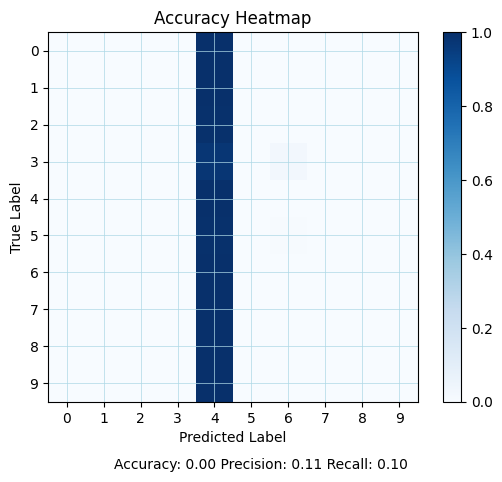

In [260]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

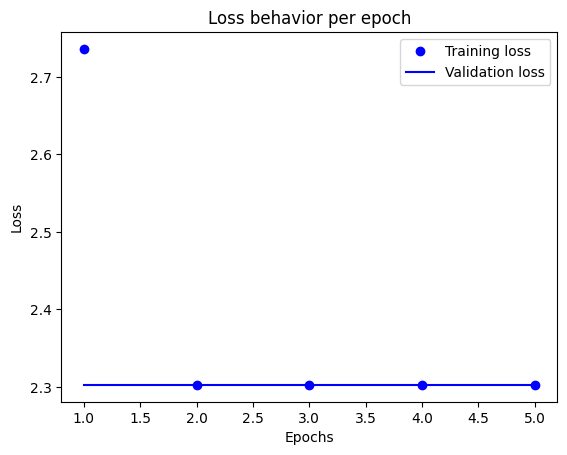

In [261]:
plot_loss_per_epoch(fit_history)

## Função de ativação

### Sigmoid

De um modo geral, a utilização da sigmoid apenas na `hidden_layer` não trouxe melhoras significativas se comparado com o nosso caso base mostrado anteriormente. A própria característica da função de limitar os valores de entrada em um range `[0, 1]` nos mostra que talvez esta função seja mais útil para casos de classificação binária e não para `multi-labels`.


Esta característica também pode levar ao desaparecimento do gradiente, ou seja, os gradientes da `hidden_layer` podem ter ficado muito pequenos ao ponto de o ajuste dos pesos não surtir efeito no treinamento. Tal fato explicaria o motivo de os melhores resultados terem sido obtidos no caso onde a sigmoid foi utilizada apenas na camada de saída, uma vez que, contendo as 10 classes possíveis, valores entre 0 e 1 passam a indicar a probabilidade de um valor representar ou não aquela classe.

In [262]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15),
    Dense(10, activation='sigmoid')
])

In [263]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.7664 - accuracy: 0.8017 - val_loss: 0.4237 - val_accuracy: 0.8861
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4062 - accuracy: 0.8884 - val_loss: 0.3498 - val_accuracy: 0.8997
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3569 - accuracy: 0.8994 - val_loss: 0.3238 - val_accuracy: 0.9064
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3344 - accuracy: 0.9054 - val_loss: 0.3081 - val_accuracy: 0.9123
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3210 - accuracy: 0.9088 - val_loss: 0.3012 - val_accuracy: 0.9147


In [264]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.3016 - accuracy: 0.9134 - 628ms/epoch - 2ms/step
313/313 [==============================] - 1s 3ms/step


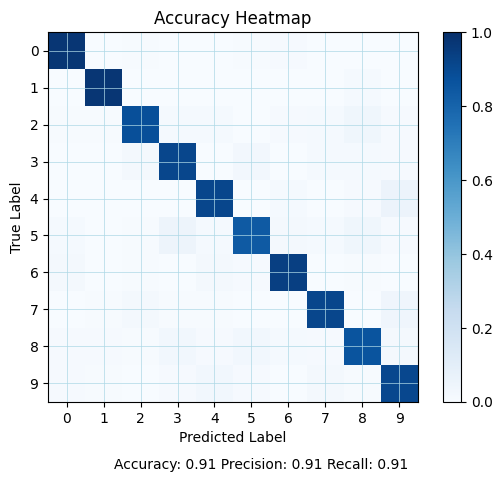

In [265]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

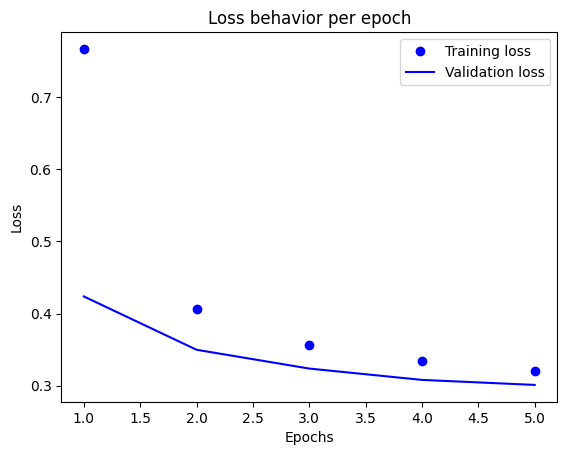

In [266]:
plot_loss_per_epoch(fit_history)

### ReLU

Os resultados da utilização da ReLU foram piores do que a sigmoid. Enquanto a sigmoid impõe um limite aos dados, a ReLU os deixa livres, ou seja, ilimitados. Tal característica pode acabar dificultando uma interpretação probabilística para a classificação, o que talvez mostre que seu uso não seja o mais preferível, ou talvez performe melhor quando combinada com outra função.

In [267]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15),
    Dense(10, activation='relu')
])

In [268]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 4.2792 - accuracy: 0.0946 - val_loss: 3.5027 - val_accuracy: 0.0938
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 4.5127 - accuracy: 0.1335 - val_loss: 6.8633 - val_accuracy: 0.0995
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 7.0369 - accuracy: 0.0985 - val_loss: 6.8633 - val_accuracy: 0.0995
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 7.0369 - accuracy: 0.0985 - val_loss: 6.8633 - val_accuracy: 0.0995
Epoch 5/5
1500/1500 [==============================] - 4s 2ms/step - loss: 7.0369 - accuracy: 0.0985 - val_loss: 6.8633 - val_accuracy: 0.0995


In [269]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 7.0296 - accuracy: 0.0980 - 507ms/epoch - 2ms/step
313/313 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


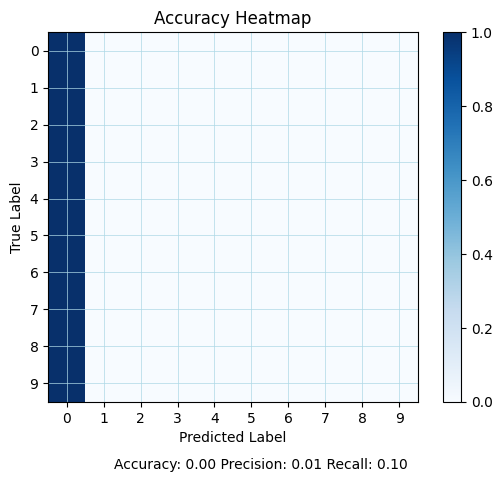

In [270]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

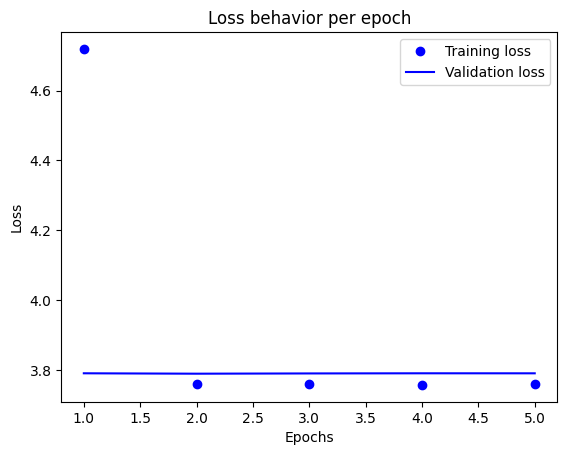

In [71]:
plot_loss_per_epoch(fit_history)

### Softmax

A utilização da softmax na `hidden_layer` não se mostrou efetiva, provavelmente pela sua tendência de impor probabilidades mutuamente exclusivas a todos os neurônios, o que pode fazer com que ela não consiga capturar representações complexas dos dados de entrada. Por outro lado, se olharmos para a camada de saída, vemos que ela pode se adequar bem, isso porque ela garante que a soma das probabilidades de saída somam 1, o que parece ser ideal para o problema de classificação que estamos abordando (inclusive, a softmax forneceu resultados melhores que o uso da sigmoid)

In [271]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15),
    Dense(10, activation='softmax')
])

In [272]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.7402 - accuracy: 0.8054 - val_loss: 0.4114 - val_accuracy: 0.8897
Epoch 2/5
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3987 - accuracy: 0.8883 - val_loss: 0.3440 - val_accuracy: 0.9028
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3528 - accuracy: 0.9002 - val_loss: 0.3219 - val_accuracy: 0.9103
Epoch 4/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3316 - accuracy: 0.9058 - val_loss: 0.3095 - val_accuracy: 0.9133
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3187 - accuracy: 0.9088 - val_loss: 0.3004 - val_accuracy: 0.9160


In [273]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.3005 - accuracy: 0.9154 - 518ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step


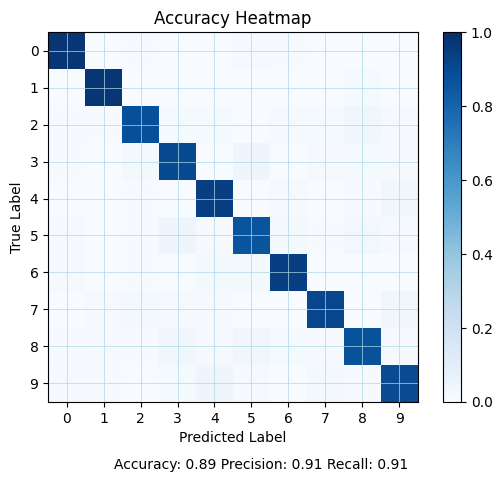

In [274]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

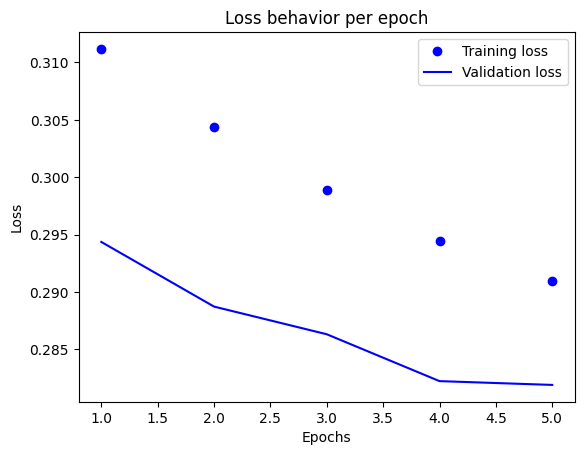

In [91]:
plot_loss_per_epoch(fit_history)

### ReLU + Softmax

A ReLU mitiga os casos de desaparecimento do gradiente que acontecem com o uso da sigmoid, o que contribui para uma convergência mais rápida no processo de treinamento e por isso é mais interessante de ser utilizada na `hidden_layer`. Estas características somadas à sua não linearidade permite que a `hidden_layer` seja capaz de aprender representações mais complexas. Por fim, somamos a tudo isso uma distribuição calibrada de probabilidades entre classes, contribuindo para que o modelo fique mais completo.

In [275]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [276]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.8397 - accuracy: 0.7703 - val_loss: 0.4267 - val_accuracy: 0.8820
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4009 - accuracy: 0.8873 - val_loss: 0.3452 - val_accuracy: 0.9031
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3484 - accuracy: 0.9006 - val_loss: 0.3137 - val_accuracy: 0.9116
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3234 - accuracy: 0.9079 - val_loss: 0.2988 - val_accuracy: 0.9159
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3067 - accuracy: 0.9126 - val_loss: 0.2856 - val_accuracy: 0.9188


In [277]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.2867 - accuracy: 0.9175 - 530ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step


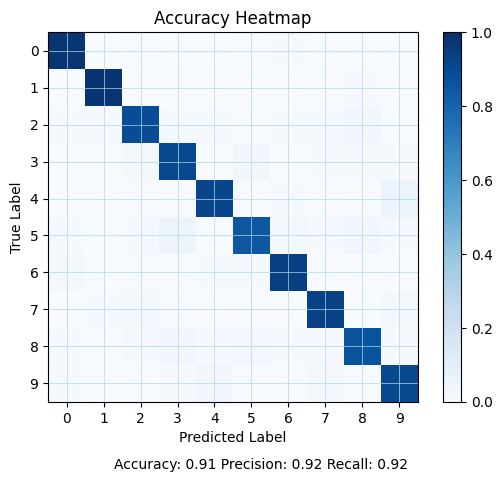

In [278]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

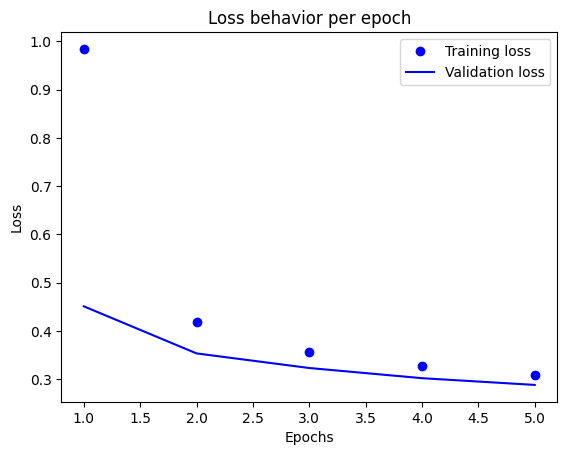

In [101]:
plot_loss_per_epoch(fit_history)

## Batch size

Conforme aumentamos o batch_size, duas coisas ficam bem notórias:
1. O treinamento se torna mais rápido devido a um maior número de dados sendo processados em paralelo e otimizando a utilização dos recursos computacionais. Além disso, o número de vezes que os pesos terão de ser recalculados diminui, já que com um tamanho de batch maior, serão necessários menos batches para o treinamento.
2. A performance do modelo vai piorando, o que pode ser resultados de alguns fatores como:
  - Ruídos sendo introduzidos no gradiente, ainda mais dado o contexto da base de dados que já tende a ser ruidosa
  - O algoritmo de otimização SGD tende a não funcionar muito bem com um `batch_size` grande
  - Um `batch_size` grande geralmente requer ajuste no nível do `learning_rate`, o que faz total sentido se pensar que, por exemplo, não se pode esperar que o aprendizado sobre o conteúdo de uma carta seja igual ao aprendizado de uma enciclopédia.

Dada a observação deste comportamento, fixaremos daqui em diante o nosso `batch_size = 10`

### batch_size = 16

In [279]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [280]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5
3000/3000 [==============================] - 17s 6ms/step - loss: 0.6851 - accuracy: 0.8107 - val_loss: 0.3569 - val_accuracy: 0.9003
Epoch 2/5
3000/3000 [==============================] - 8s 3ms/step - loss: 0.3443 - accuracy: 0.9015 - val_loss: 0.2969 - val_accuracy: 0.9151
Epoch 3/5
3000/3000 [==============================] - 6s 2ms/step - loss: 0.3009 - accuracy: 0.9147 - val_loss: 0.2728 - val_accuracy: 0.9228
Epoch 4/5
3000/3000 [==============================] - 7s 2ms/step - loss: 0.2781 - accuracy: 0.9206 - val_loss: 0.2636 - val_accuracy: 0.9239
Epoch 5/5
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2626 - accuracy: 0.9266 - val_loss: 0.2464 - val_accuracy: 0.9309


In [281]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.2473 - accuracy: 0.9308 - 684ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


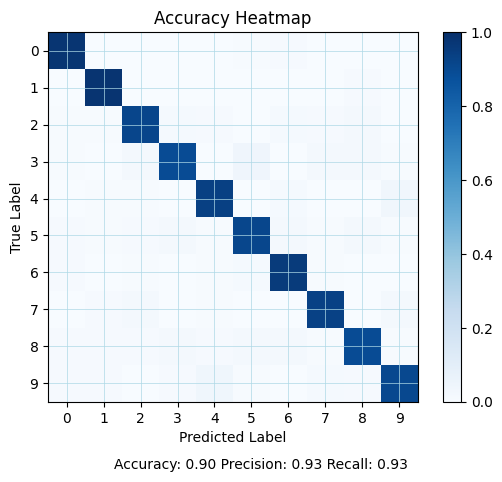

In [282]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

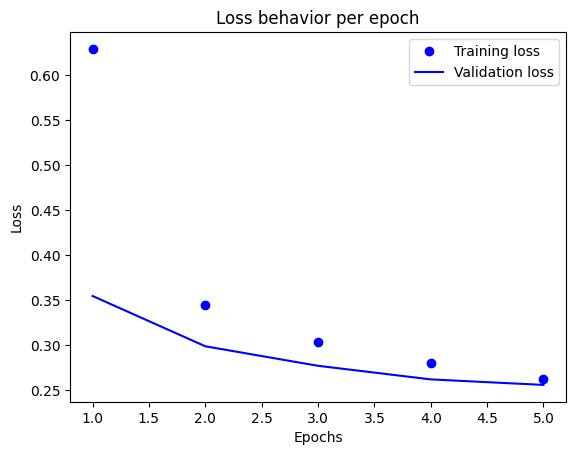

In [108]:
plot_loss_per_epoch(fit_history)

### batch_size = 64

In [283]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [284]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 [==============================] - 3s 4ms/step - loss: 1.1545 - accuracy: 0.6804 - val_loss: 0.5860 - val_accuracy: 0.8553
Epoch 2/5
750/750 [==============================] - 5s 7ms/step - loss: 0.5179 - accuracy: 0.8661 - val_loss: 0.4169 - val_accuracy: 0.8903
Epoch 3/5
750/750 [==============================] - 3s 4ms/step - loss: 0.4186 - accuracy: 0.8858 - val_loss: 0.3646 - val_accuracy: 0.9024
Epoch 4/5
750/750 [==============================] - 4s 5ms/step - loss: 0.3772 - accuracy: 0.8943 - val_loss: 0.3375 - val_accuracy: 0.9071
Epoch 5/5
750/750 [==============================] - 4s 5ms/step - loss: 0.3526 - accuracy: 0.8996 - val_loss: 0.3208 - val_accuracy: 0.9109


In [285]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.3246 - accuracy: 0.9091 - 618ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


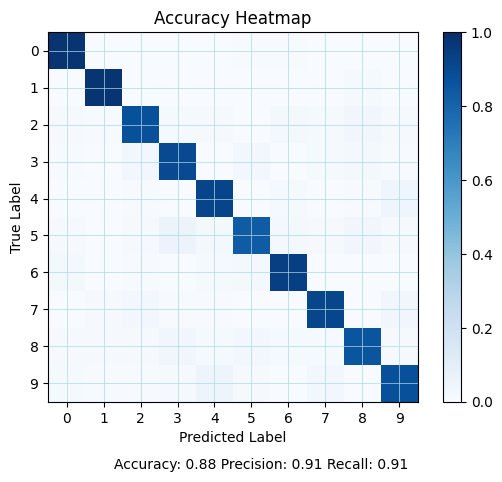

In [286]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

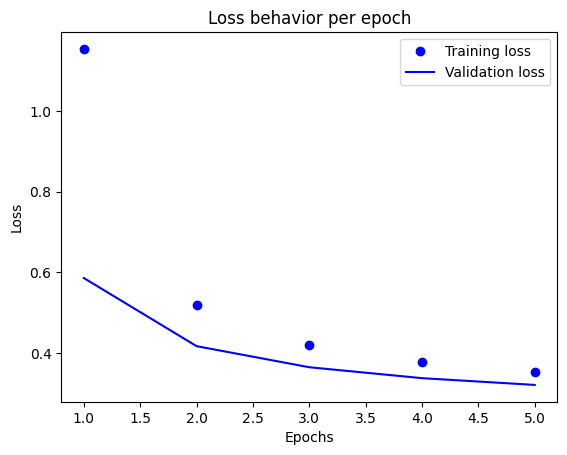

In [287]:
plot_loss_per_epoch(fit_history)

### batch_size = 256

In [288]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [289]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_split=0.2)

Epoch 1/5
188/188 [==============================] - 2s 6ms/step - loss: 1.9478 - accuracy: 0.3708 - val_loss: 1.6077 - val_accuracy: 0.5369
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 1.3754 - accuracy: 0.6276 - val_loss: 1.1434 - val_accuracy: 0.7147
Epoch 3/5
188/188 [==============================] - 1s 4ms/step - loss: 1.0124 - accuracy: 0.7525 - val_loss: 0.8543 - val_accuracy: 0.8057
Epoch 4/5
188/188 [==============================] - 2s 8ms/step - loss: 0.7960 - accuracy: 0.8073 - val_loss: 0.6898 - val_accuracy: 0.8340
Epoch 5/5
188/188 [==============================] - 1s 7ms/step - loss: 0.6707 - accuracy: 0.8341 - val_loss: 0.5927 - val_accuracy: 0.8532


In [290]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.6016 - accuracy: 0.8542 - 520ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


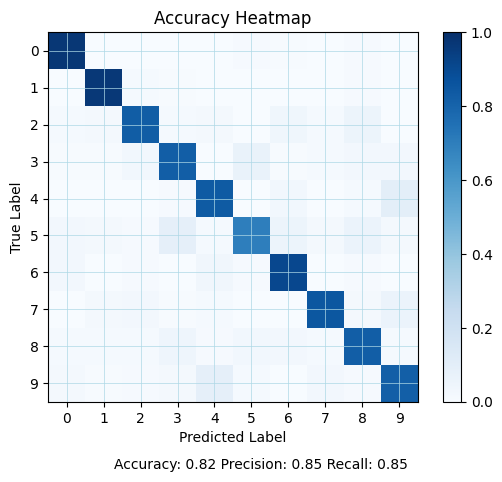

In [291]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

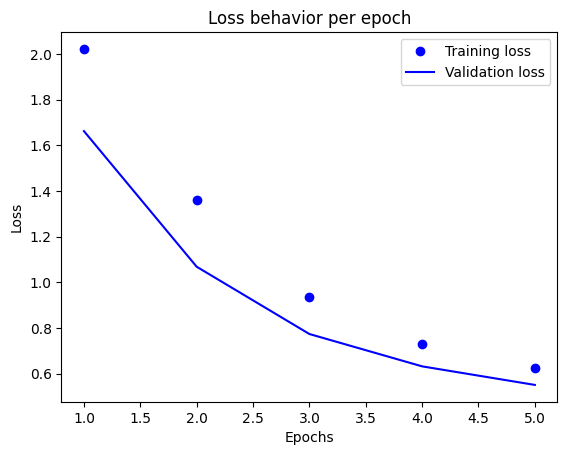

In [118]:
plot_loss_per_epoch(fit_history)

## Quantidade de camadas

Neste contexto, podemos ver que a utilização de 2 `hidden_layers` trouxe uma ligeira melhora para o modelo, com uma `loss` menor e ácuracia maior (tanto geral quanto entre as classes), mas além disso o modelo piorou de apresentar avanços. Vários fatores podem ter levado a este comportamento, mas entre os principais estão:

1. Overfitting causado pela adesão de complexidade à rede e o crescimento do número de parâmetros internos
2. Dificuldade inerente ao crescimento da rede, uma vez que se torna mais complexa e para fornecer melhora significativa talvez seja necessário revisitar combinações de funções de ativação, trocar o otimizador ou até mesmo aumentar o número de épocas
3. Adesão de redundância ou irrelevância à rede, o que pode ser minimizado com a utilização de `dropout`

### 2 hidden layers

In [292]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [293]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.5777 - accuracy: 0.8289 - val_loss: 0.2963 - val_accuracy: 0.9158
Epoch 2/5
4800/4800 [==============================] - 25s 5ms/step - loss: 0.2865 - accuracy: 0.9166 - val_loss: 0.2544 - val_accuracy: 0.9285
Epoch 3/5
4800/4800 [==============================] - 17s 3ms/step - loss: 0.2441 - accuracy: 0.9290 - val_loss: 0.2355 - val_accuracy: 0.9327
Epoch 4/5
4800/4800 [==============================] - 18s 4ms/step - loss: 0.2179 - accuracy: 0.9367 - val_loss: 0.2082 - val_accuracy: 0.9410
Epoch 5/5
4800/4800 [==============================] - 24s 5ms/step - loss: 0.1989 - accuracy: 0.9417 - val_loss: 0.1950 - val_accuracy: 0.9451


In [294]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.1923 - accuracy: 0.9450 - 906ms/epoch - 3ms/step
313/313 [==============================] - 1s 3ms/step


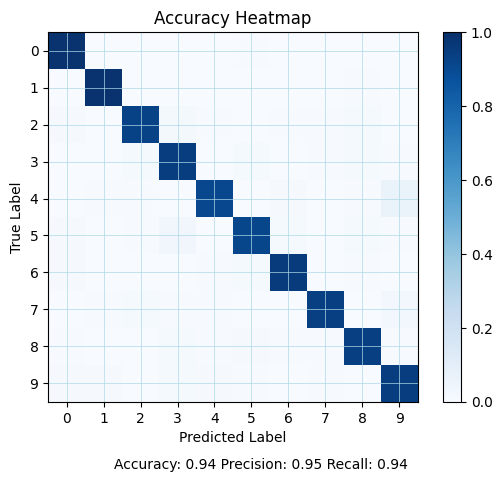

In [295]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

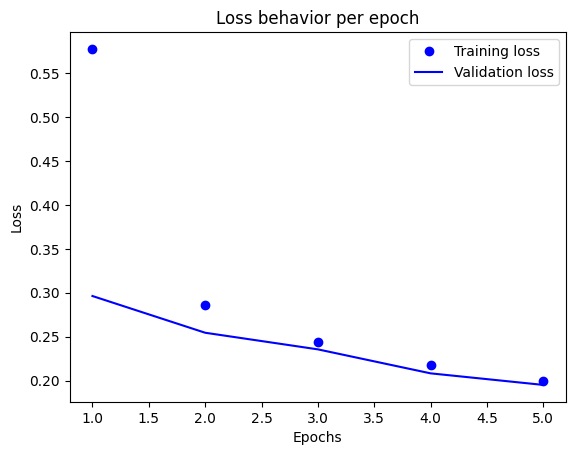

In [296]:
plot_loss_per_epoch(fit_history)

### 4 hidden layers

In [297]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [298]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 13s 2ms/step - loss: 0.7657 - accuracy: 0.7499 - val_loss: 0.3403 - val_accuracy: 0.8986
Epoch 2/5
4800/4800 [==============================] - 13s 3ms/step - loss: 0.3010 - accuracy: 0.9103 - val_loss: 0.2490 - val_accuracy: 0.9259
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.2402 - accuracy: 0.9286 - val_loss: 0.2363 - val_accuracy: 0.9247
Epoch 4/5
4800/4800 [==============================] - 12s 2ms/step - loss: 0.2116 - accuracy: 0.9364 - val_loss: 0.2794 - val_accuracy: 0.9164
Epoch 5/5
4800/4800 [==============================] - 12s 2ms/step - loss: 0.1906 - accuracy: 0.9415 - val_loss: 0.2091 - val_accuracy: 0.9371


In [299]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.2093 - accuracy: 0.9373 - 556ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


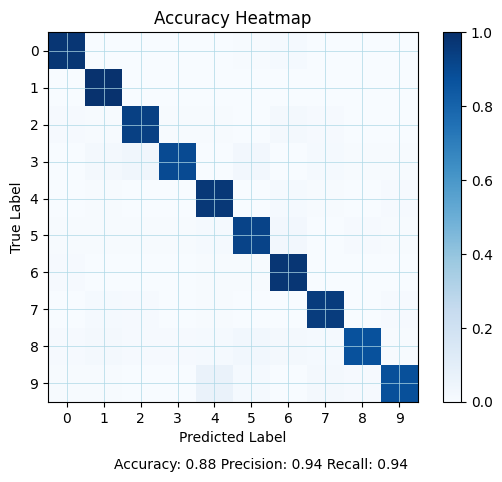

In [300]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

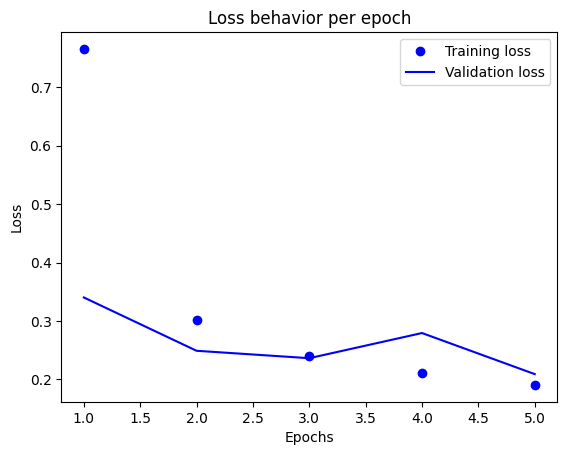

In [301]:
plot_loss_per_epoch(fit_history)

### 10 hidden layers

In [302]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [303]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 17s 3ms/step - loss: 1.7391 - accuracy: 0.3568 - val_loss: 0.8279 - val_accuracy: 0.7452
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.6704 - accuracy: 0.8083 - val_loss: 0.5757 - val_accuracy: 0.8189
Epoch 3/5
4800/4800 [==============================] - 15s 3ms/step - loss: 0.4347 - accuracy: 0.8831 - val_loss: 0.3844 - val_accuracy: 0.9022
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.3445 - accuracy: 0.9075 - val_loss: 0.3901 - val_accuracy: 0.9052
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.2983 - accuracy: 0.9195 - val_loss: 0.2693 - val_accuracy: 0.9321


In [304]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.2780 - accuracy: 0.9274 - 680ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


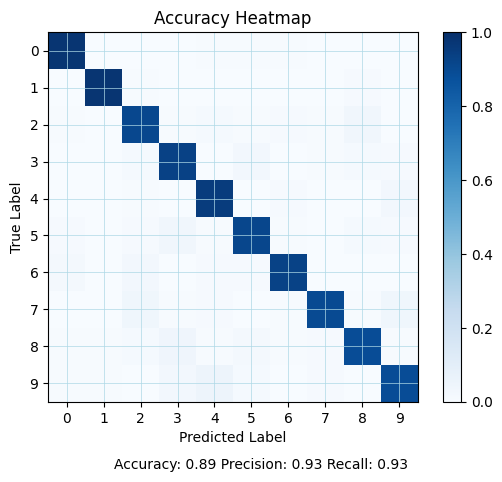

In [305]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

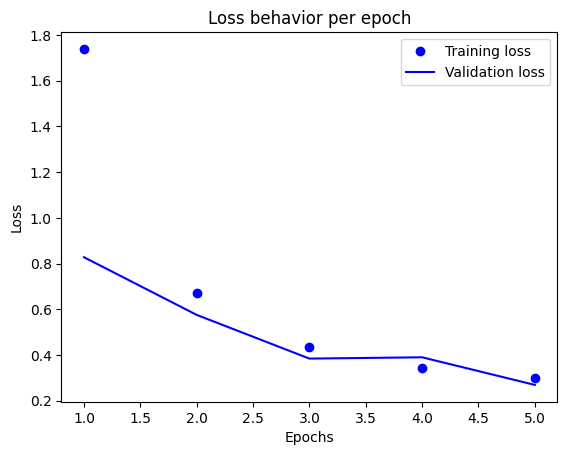

In [306]:
plot_loss_per_epoch(fit_history)

## Quantidade de neurônios

Aqui, podemos ver que o acréscimo de neurônios na rede impacta diretamente no aprendizado do modelo. Isso se torna ainda mais notório ao perceber que todos os casos abaixo tiveram métricas superiores a todos os anteriores que utilizavam menos neurônios. No entanto, devemos nos atentar ao fato de que após a configuração `200 -> 125` os resultados obtidos não surtiram efeito plausível, mesmo dobrando o número de neurônios.

Talvez não seja possível afirmar que está ocorrendo um overfitting, porque os resultados de validação e testes estão satisfatórios e se mantiveram constantes, mas podemos afirmar que acrescentamos complexidade e conexões desnecessárias à nossa rede. Talvez tenhamos atingido o limite de aprendizagem possível para esta quantidade de `hidden_layers` ou talvez sejam necessárias mais épocas, porque pode-se notar que a acurácia do modelo seguia melhorando ao decorrer do tempo, então talvez mais épocas levassem a melhores resultados. Ou seja, é possível que tunando os demais hiperparâmetros possamos avançar deste limite.


Por ora, melhoramos significativamente a performance da nossa rede com o acréscimo de neurônios. Para a nossa configuração ideal, utilizaremos `neurons = 200 -> 125`

### 30 -> 15

In [307]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(30, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='softmax')
])

In [308]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 13s 3ms/step - loss: 0.5598 - accuracy: 0.8353 - val_loss: 0.2870 - val_accuracy: 0.9192
Epoch 2/5
4800/4800 [==============================] - 13s 3ms/step - loss: 0.2673 - accuracy: 0.9221 - val_loss: 0.2180 - val_accuracy: 0.9377
Epoch 3/5
4800/4800 [==============================] - 11s 2ms/step - loss: 0.2090 - accuracy: 0.9394 - val_loss: 0.1853 - val_accuracy: 0.9482
Epoch 4/5
4800/4800 [==============================] - 11s 2ms/step - loss: 0.1757 - accuracy: 0.9482 - val_loss: 0.1659 - val_accuracy: 0.9541
Epoch 5/5
4800/4800 [==============================] - 11s 2ms/step - loss: 0.1538 - accuracy: 0.9540 - val_loss: 0.1660 - val_accuracy: 0.9520


In [309]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.1664 - accuracy: 0.9510 - 524ms/epoch - 2ms/step
313/313 [==============================] - 0s 1ms/step


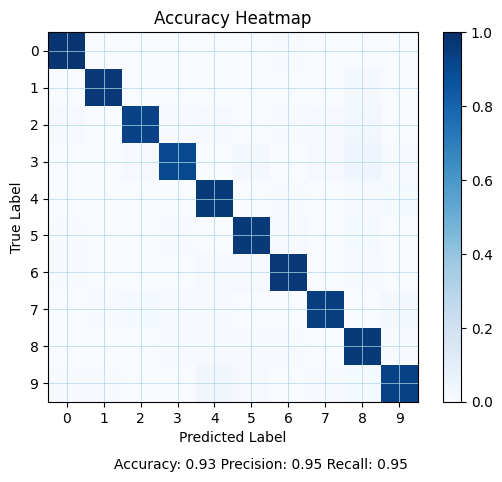

In [310]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

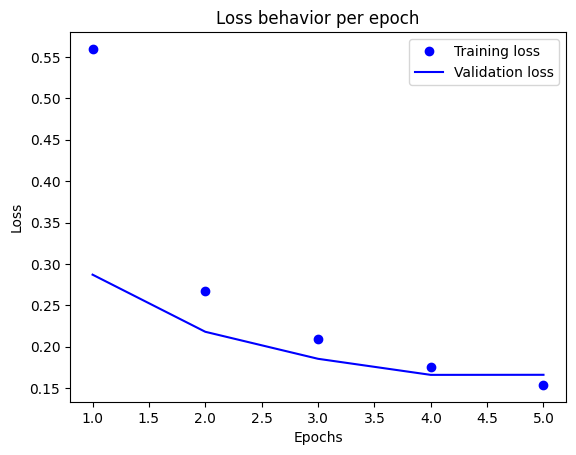

In [311]:
plot_loss_per_epoch(fit_history)

### 100 -> 50

In [312]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='softmax')
])

In [313]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 15s 3ms/step - loss: 0.4541 - accuracy: 0.8736 - val_loss: 0.2434 - val_accuracy: 0.9309
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.2221 - accuracy: 0.9365 - val_loss: 0.1827 - val_accuracy: 0.9495
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.1669 - accuracy: 0.9520 - val_loss: 0.1540 - val_accuracy: 0.9571
Epoch 4/5
4800/4800 [==============================] - 13s 3ms/step - loss: 0.1337 - accuracy: 0.9619 - val_loss: 0.1342 - val_accuracy: 0.9618
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.1120 - accuracy: 0.9672 - val_loss: 0.1162 - val_accuracy: 0.9665


In [314]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.1066 - accuracy: 0.9679 - 592ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


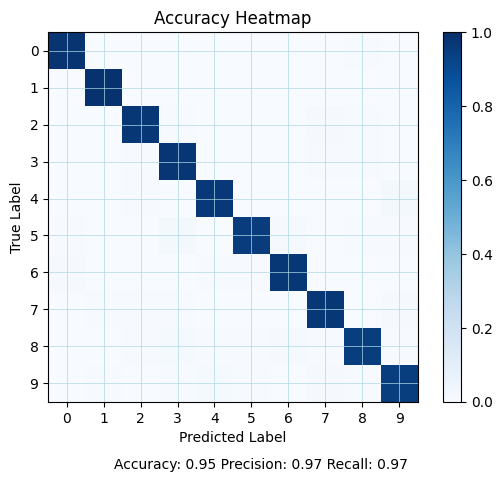

In [315]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

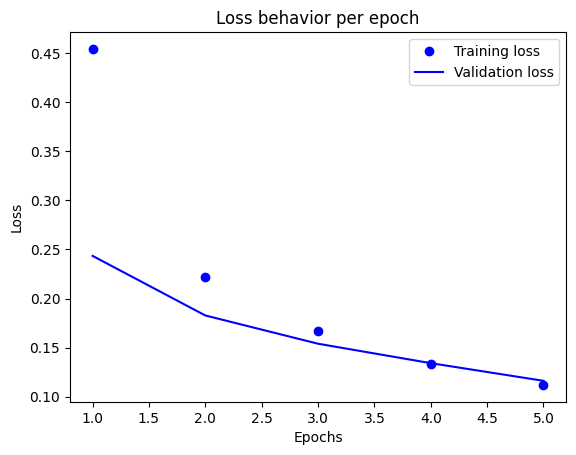

In [316]:
plot_loss_per_epoch(fit_history)

### 250 -> 125

In [317]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(250, activation='relu'),
    Dense(125, activation='relu'),
    Dense(10, activation='softmax')
])

In [318]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 24s 5ms/step - loss: 0.4105 - accuracy: 0.8855 - val_loss: 0.2349 - val_accuracy: 0.9311
Epoch 2/5
4800/4800 [==============================] - 21s 4ms/step - loss: 0.2000 - accuracy: 0.9418 - val_loss: 0.1594 - val_accuracy: 0.9563
Epoch 3/5
4800/4800 [==============================] - 26s 5ms/step - loss: 0.1459 - accuracy: 0.9573 - val_loss: 0.1434 - val_accuracy: 0.9592
Epoch 4/5
4800/4800 [==============================] - 39s 8ms/step - loss: 0.1149 - accuracy: 0.9655 - val_loss: 0.1217 - val_accuracy: 0.9629
Epoch 5/5
4800/4800 [==============================] - 24s 5ms/step - loss: 0.0930 - accuracy: 0.9729 - val_loss: 0.1085 - val_accuracy: 0.9662


In [319]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.1068 - accuracy: 0.9686 - 702ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


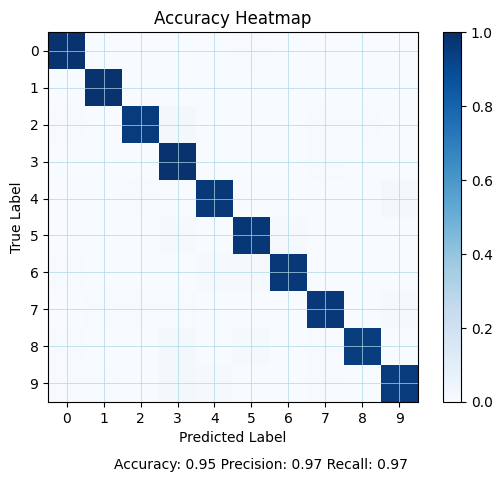

In [320]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

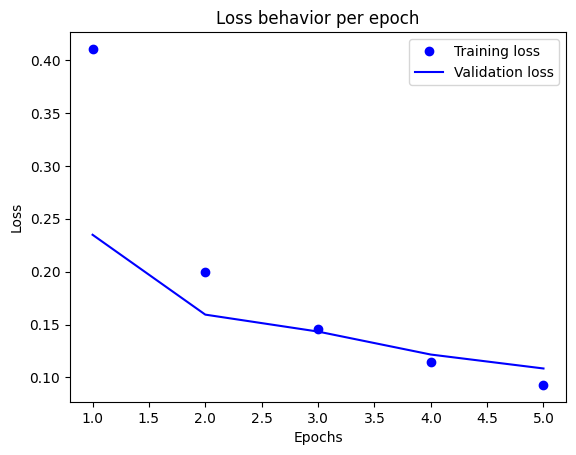

In [321]:
plot_loss_per_epoch(fit_history)

### 250 -> 175

In [322]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(250, activation='relu'),
    Dense(125, activation='relu'),
    Dense(10, activation='softmax')
])

In [323]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 20s 4ms/step - loss: 0.4152 - accuracy: 0.8858 - val_loss: 0.2421 - val_accuracy: 0.9293
Epoch 2/5
4800/4800 [==============================] - 22s 5ms/step - loss: 0.1994 - accuracy: 0.9425 - val_loss: 0.1686 - val_accuracy: 0.9514
Epoch 3/5
4800/4800 [==============================] - 22s 5ms/step - loss: 0.1464 - accuracy: 0.9576 - val_loss: 0.1599 - val_accuracy: 0.9526
Epoch 4/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.1149 - accuracy: 0.9667 - val_loss: 0.1162 - val_accuracy: 0.9657
Epoch 5/5
4800/4800 [==============================] - 35s 7ms/step - loss: 0.0935 - accuracy: 0.9729 - val_loss: 0.1147 - val_accuracy: 0.9662


In [324]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.1097 - accuracy: 0.9668 - 686ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


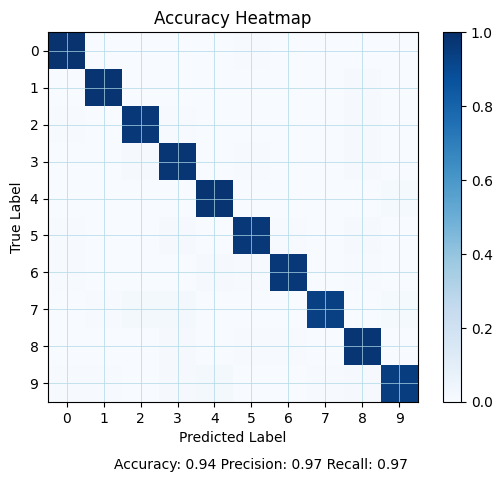

In [325]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

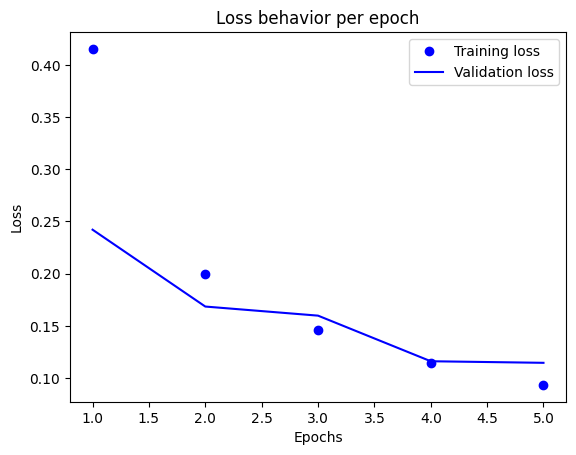

In [326]:
plot_loss_per_epoch(fit_history)

### 500 -> 175

In [327]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(500, activation='relu'),
    Dense(175, activation='relu'),
    Dense(10, activation='softmax')
])

In [328]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 38s 8ms/step - loss: 0.3843 - accuracy: 0.8958 - val_loss: 0.2204 - val_accuracy: 0.9367
Epoch 2/5
4800/4800 [==============================] - 32s 7ms/step - loss: 0.1895 - accuracy: 0.9450 - val_loss: 0.1601 - val_accuracy: 0.9550
Epoch 3/5
4800/4800 [==============================] - 27s 6ms/step - loss: 0.1354 - accuracy: 0.9605 - val_loss: 0.1257 - val_accuracy: 0.9659
Epoch 4/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.1048 - accuracy: 0.9693 - val_loss: 0.1109 - val_accuracy: 0.9687
Epoch 5/5
4800/4800 [==============================] - 26s 5ms/step - loss: 0.0834 - accuracy: 0.9761 - val_loss: 0.1025 - val_accuracy: 0.9702


In [329]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.0965 - accuracy: 0.9714 - 1s/epoch - 3ms/step
313/313 [==============================] - 1s 3ms/step


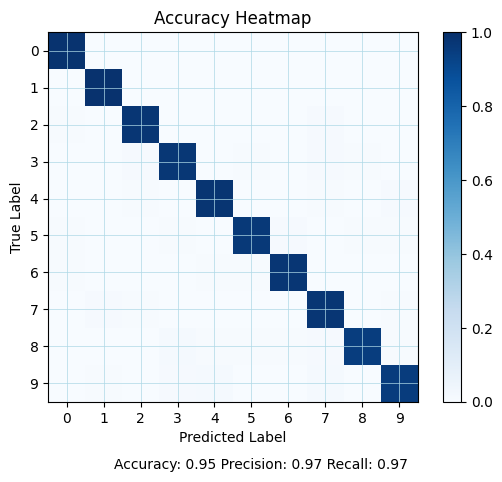

In [330]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

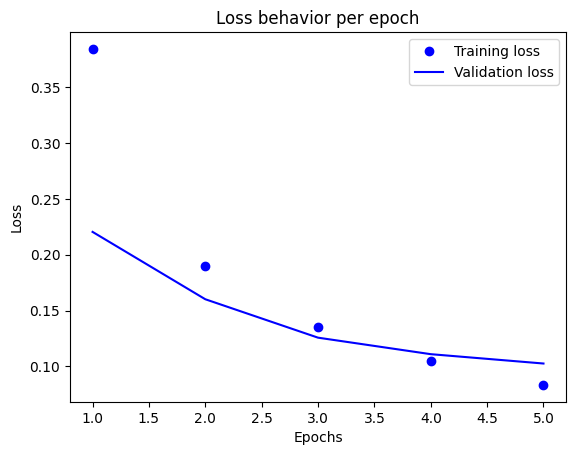

In [331]:
plot_loss_per_epoch(fit_history)

### 525 -> 300

In [332]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(525, activation='relu'),
    Dense(300, activation='relu'),
    Dense(10, activation='softmax')
])

In [333]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 30s 6ms/step - loss: 0.3972 - accuracy: 0.8910 - val_loss: 0.2141 - val_accuracy: 0.9375
Epoch 2/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.1866 - accuracy: 0.9460 - val_loss: 0.1676 - val_accuracy: 0.9529
Epoch 3/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.1352 - accuracy: 0.9609 - val_loss: 0.1394 - val_accuracy: 0.9571
Epoch 4/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.1054 - accuracy: 0.9699 - val_loss: 0.1092 - val_accuracy: 0.9691
Epoch 5/5
4800/4800 [==============================] - 28s 6ms/step - loss: 0.0850 - accuracy: 0.9759 - val_loss: 0.0989 - val_accuracy: 0.9724


In [334]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.0905 - accuracy: 0.9713 - 978ms/epoch - 3ms/step
313/313 [==============================] - 1s 3ms/step


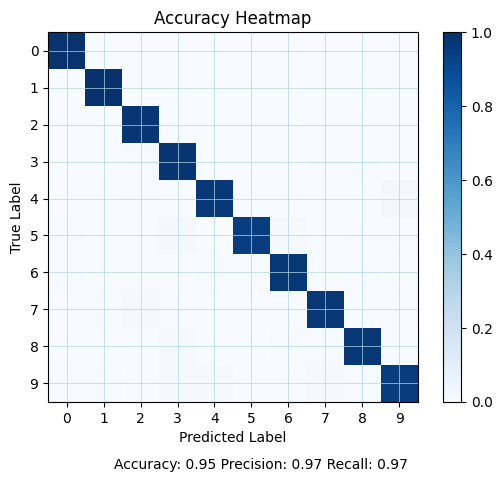

In [335]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

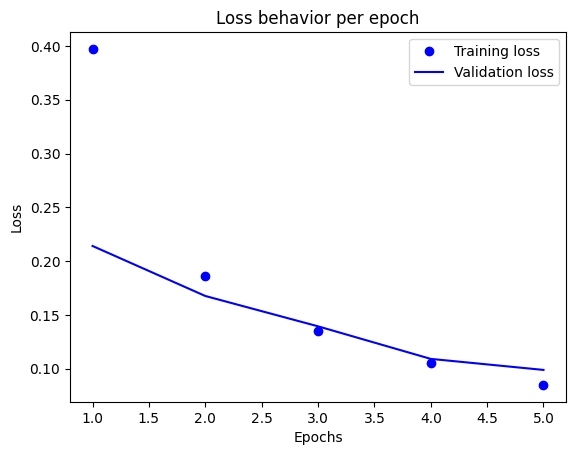

In [336]:
plot_loss_per_epoch(fit_history)

## Dropout simple

Na análise da quantidade de camadas, vimos que, para uma mesma quantidade de épocas, o modelo apresentou resultados inferiores ao adicionar mais complexidade. Na análise de quantidade de neurônios, vimos que o modelo estagnou ao acrescentar mais neurônios à rede. Aqui vamos utilizar o `dropout` sobre o modelo com mais neurônios para verificar como ele se comporta.

NOTA: o processo atual é apenas demonstrativo, seguiremos com a configuração de `hidden_layers = 2`

Como resultado, podemos notar que, de modo geral, o `dropout` não trouxe melhoria nos resultados. Isto porque o mínimo valor utilizado nos trouxe para valores bem próximos daqueles obtidos sem o dropout. Claro que poderíamos utilizar outras configurações, como porcentagens diferentes entre as camadas, mas de um modo geral adotar o uso de menos neurônios parece mais promissor e traz menos complexidade.

Por fim, alguns casos podem ser citados como responsáveis pelo não sucesso da utilização do `dropout`:
1. Como citado anteriormente, podem ser feitas tentativas de modificar as porcentagens entre as camadas, ou utilizar em uma camada e não em outra...
2. Anteriormente observamos que provavelmente não estava havendo overfitting no caso do acréscimo do número de neurônios, então a utilização de `dropout` acaba não sendo muito efetiva
3. O `dropout` é uma técnica que ajuda bastante redes mais complexas, talvez a nossa rede ainda esteja muito simples para sofrer o impacto dele

### 05%

In [337]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(525, activation='relu'),
    Dropout(0.05),
    Dense(300, activation='relu'),
    Dropout(0.05),
    Dense(10, activation='softmax')
])

In [338]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 31s 6ms/step - loss: 0.4103 - accuracy: 0.8863 - val_loss: 0.2128 - val_accuracy: 0.9408
Epoch 2/5
4800/4800 [==============================] - 32s 7ms/step - loss: 0.1998 - accuracy: 0.9425 - val_loss: 0.1568 - val_accuracy: 0.9534
Epoch 3/5
4800/4800 [==============================] - 30s 6ms/step - loss: 0.1459 - accuracy: 0.9577 - val_loss: 0.1329 - val_accuracy: 0.9625
Epoch 4/5
4800/4800 [==============================] - 30s 6ms/step - loss: 0.1148 - accuracy: 0.9667 - val_loss: 0.1114 - val_accuracy: 0.9674
Epoch 5/5
4800/4800 [==============================] - 32s 7ms/step - loss: 0.0928 - accuracy: 0.9727 - val_loss: 0.0999 - val_accuracy: 0.9701


In [339]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.0930 - accuracy: 0.9717 - 1s/epoch - 3ms/step
313/313 [==============================] - 2s 4ms/step


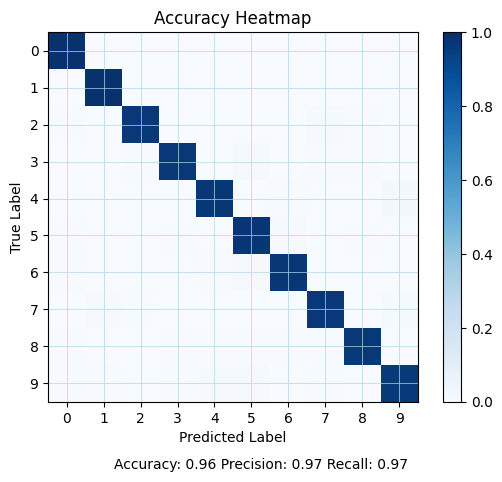

In [340]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

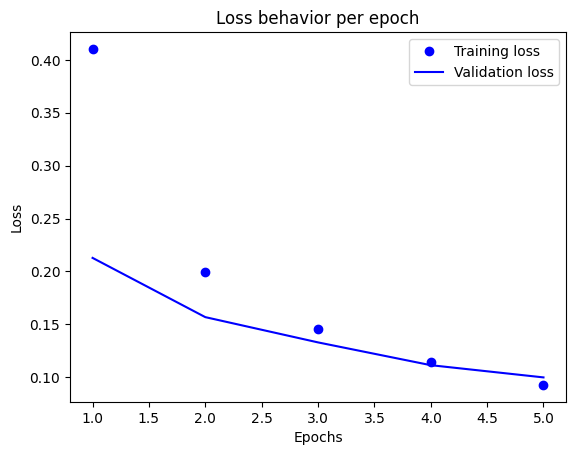

In [341]:
plot_loss_per_epoch(fit_history)

### 10%

In [342]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(525, activation='relu'),
    Dropout(0.1),
    Dense(300, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

In [343]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 34s 7ms/step - loss: 0.4278 - accuracy: 0.8799 - val_loss: 0.2091 - val_accuracy: 0.9418
Epoch 2/5
4800/4800 [==============================] - 33s 7ms/step - loss: 0.2032 - accuracy: 0.9409 - val_loss: 0.1512 - val_accuracy: 0.9583
Epoch 3/5
4800/4800 [==============================] - 34s 7ms/step - loss: 0.1485 - accuracy: 0.9571 - val_loss: 0.1234 - val_accuracy: 0.9647
Epoch 4/5
4800/4800 [==============================] - 32s 7ms/step - loss: 0.1174 - accuracy: 0.9649 - val_loss: 0.1054 - val_accuracy: 0.9697
Epoch 5/5
4800/4800 [==============================] - 32s 7ms/step - loss: 0.0955 - accuracy: 0.9719 - val_loss: 0.0982 - val_accuracy: 0.9703


In [344]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 2s - loss: 0.0950 - accuracy: 0.9726 - 2s/epoch - 6ms/step
313/313 [==============================] - 1s 4ms/step


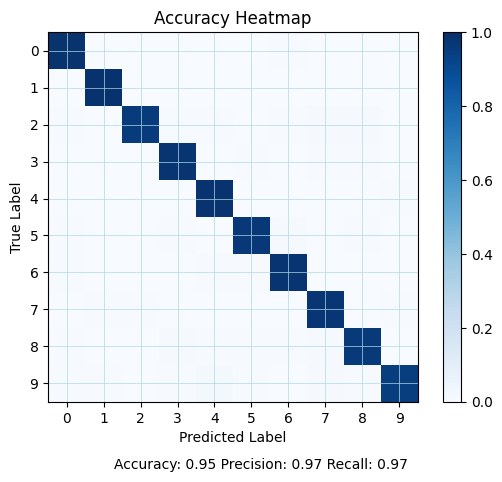

In [345]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

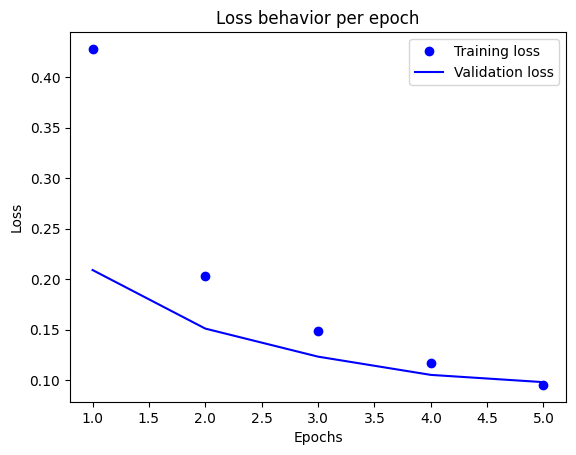

In [346]:
plot_loss_per_epoch(fit_history)

### 25%

In [347]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(525, activation='relu'),
    Dropout(0.25),
    Dense(300, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

In [348]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 33s 7ms/step - loss: 0.4697 - accuracy: 0.8616 - val_loss: 0.2130 - val_accuracy: 0.9388
Epoch 2/5
4800/4800 [==============================] - 33s 7ms/step - loss: 0.2292 - accuracy: 0.9329 - val_loss: 0.1534 - val_accuracy: 0.9551
Epoch 3/5
4800/4800 [==============================] - 31s 7ms/step - loss: 0.1702 - accuracy: 0.9497 - val_loss: 0.1209 - val_accuracy: 0.9649
Epoch 4/5
4800/4800 [==============================] - 36s 8ms/step - loss: 0.1366 - accuracy: 0.9598 - val_loss: 0.1063 - val_accuracy: 0.9680
Epoch 5/5
4800/4800 [==============================] - 32s 7ms/step - loss: 0.1159 - accuracy: 0.9657 - val_loss: 0.0977 - val_accuracy: 0.9712


In [349]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.0949 - accuracy: 0.9705 - 1s/epoch - 4ms/step
313/313 [==============================] - 1s 4ms/step


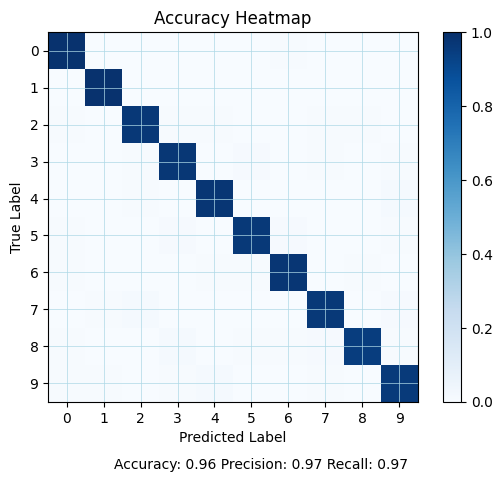

In [350]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

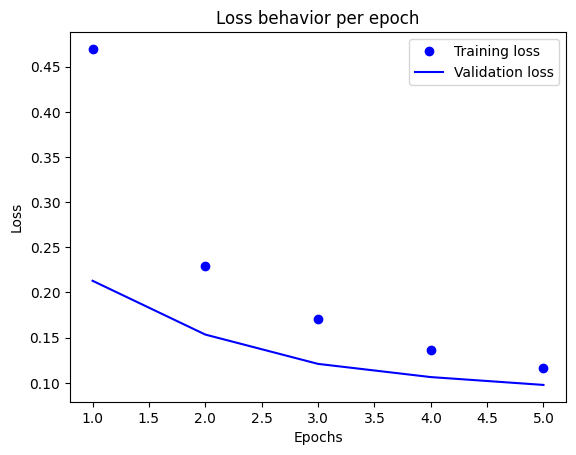

In [351]:
plot_loss_per_epoch(fit_history)

### 50%

In [352]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(525, activation='relu'),
    Dropout(0.5),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [353]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 35s 7ms/step - loss: 0.5945 - accuracy: 0.8161 - val_loss: 0.2282 - val_accuracy: 0.9315
Epoch 2/5
4800/4800 [==============================] - 43s 9ms/step - loss: 0.2963 - accuracy: 0.9106 - val_loss: 0.1635 - val_accuracy: 0.9526
Epoch 3/5
4800/4800 [==============================] - 36s 7ms/step - loss: 0.2280 - accuracy: 0.9317 - val_loss: 0.1348 - val_accuracy: 0.9595
Epoch 4/5
4800/4800 [==============================] - 33s 7ms/step - loss: 0.1916 - accuracy: 0.9434 - val_loss: 0.1174 - val_accuracy: 0.9647
Epoch 5/5
4800/4800 [==============================] - 35s 7ms/step - loss: 0.1676 - accuracy: 0.9497 - val_loss: 0.1056 - val_accuracy: 0.9692


In [354]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 2s - loss: 0.1022 - accuracy: 0.9671 - 2s/epoch - 6ms/step
313/313 [==============================] - 1s 4ms/step


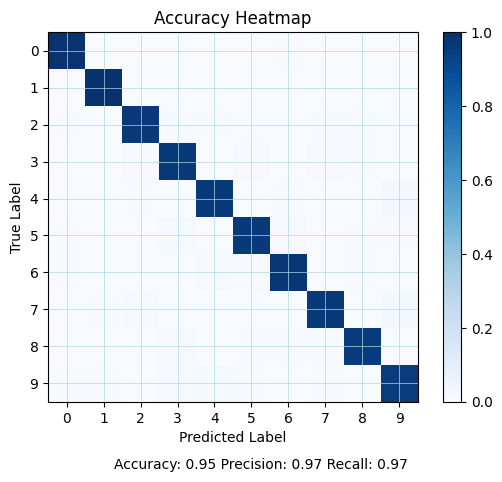

In [355]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

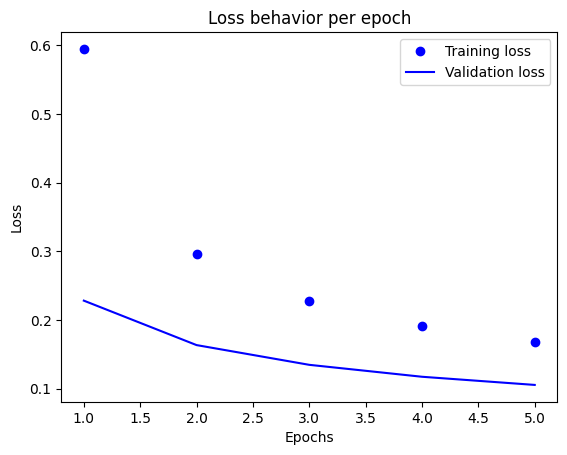

In [356]:
plot_loss_per_epoch(fit_history)

## Dropout complex

Na análise da quantidade de camadas, vimos que, para uma mesma quantidade de épocas, o modelo apresentou resultados inferiores ao adicionar mais complexidade. Na análise de quantidade de neurônios, vimos que o modelo estagnou ao acrescentar mais neurônios à rede. Aqui vamos utilizar o `dropout` sobre o modelo com mais neurônios para verificar como ele se comporta.

NOTA: o processo atual é apenas demonstrativo, seguiremos com a configuração de `hidden_layers = 2`

Como resultado, podemos notar que, de modo geral, o `dropout` não trouxe melhoria nos resultados. Isto porque o mínimo valor utilizado nos trouxe para valores bem próximos daqueles obtidos sem o dropout. Claro que poderíamos utilizar outras configurações, como porcentagens diferentes entre as camadas, mas de um modo geral adotar o uso de menos neurônios parece mais promissor e traz menos complexidade.

Por fim, alguns casos podem ser citados como responsáveis pelo não sucesso da utilização do `dropout`:
1. Como citado anteriormente, podem ser feitas tentativas de modificar as porcentagens entre as camadas, ou utilizar em uma camada e não em outra...
2. Anteriormente observamos que provavelmente não estava havendo overfitting no caso do acréscimo do número de neurônios, então a utilização de `dropout` acaba não sendo muito efetiva
3. O `dropout` é uma técnica que ajuda bastante redes mais complexas, talvez a nossa rede ainda esteja muito simples para sofrer o impacto dele

### 05%

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(15, activation='relu'),
    Dropout(0.05),
    Dense(10, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 32s 7ms/step - loss: 0.4046 - accuracy: 0.8863 - val_loss: 0.2141 - val_accuracy: 0.9397
Epoch 2/5
4800/4800 [==============================] - 38s 8ms/step - loss: 0.1936 - accuracy: 0.9439 - val_loss: 0.1519 - val_accuracy: 0.9566
Epoch 3/5
4800/4800 [==============================] - 37s 8ms/step - loss: 0.1402 - accuracy: 0.9584 - val_loss: 0.1228 - val_accuracy: 0.9643
Epoch 4/5
4800/4800 [==============================] - 38s 8ms/step - loss: 0.1108 - accuracy: 0.9678 - val_loss: 0.1095 - val_accuracy: 0.9682
Epoch 5/5
4800/4800 [==============================] - 38s 8ms/step - loss: 0.0917 - accuracy: 0.9736 - val_loss: 0.1005 - val_accuracy: 0.9716


In [ ]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.0910 - accuracy: 0.9715 - 961ms/epoch - 3ms/step
313/313 [==============================] - 1s 3ms/step


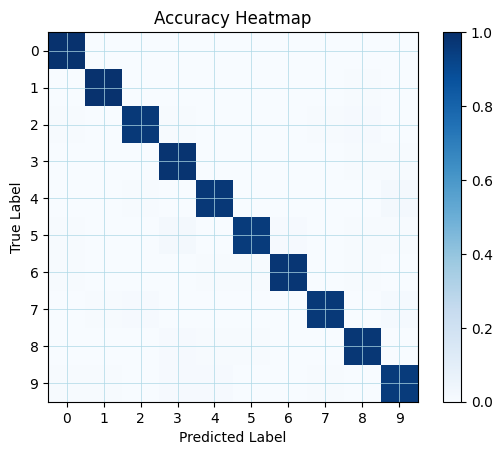

In [ ]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

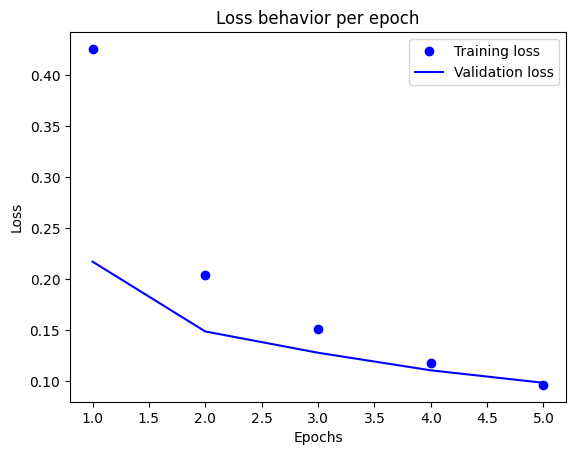

In [ ]:
plot_loss_per_epoch(fit_history)

### 30%

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 30s 6ms/step - loss: 0.4239 - accuracy: 0.8816 - val_loss: 0.2220 - val_accuracy: 0.9350
Epoch 2/5
4800/4800 [==============================] - 38s 8ms/step - loss: 0.1997 - accuracy: 0.9412 - val_loss: 0.1506 - val_accuracy: 0.9576
Epoch 3/5
4800/4800 [==============================] - 36s 7ms/step - loss: 0.1459 - accuracy: 0.9569 - val_loss: 0.1200 - val_accuracy: 0.9655
Epoch 4/5
4800/4800 [==============================] - 33s 7ms/step - loss: 0.1150 - accuracy: 0.9653 - val_loss: 0.1054 - val_accuracy: 0.9695
Epoch 5/5
4800/4800 [==============================] - 31s 6ms/step - loss: 0.0964 - accuracy: 0.9720 - val_loss: 0.0987 - val_accuracy: 0.9703


In [ ]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.0910 - accuracy: 0.9715 - 961ms/epoch - 3ms/step
313/313 [==============================] - 1s 3ms/step


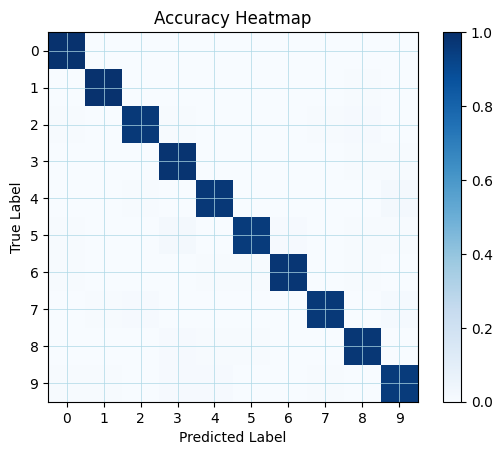

In [ ]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

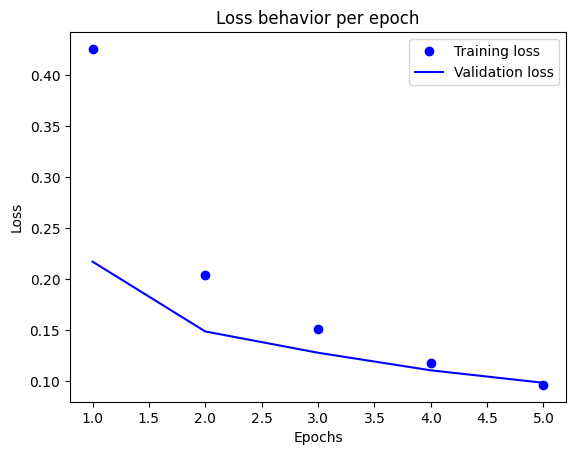

In [ ]:
plot_loss_per_epoch(fit_history)

### 50%

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.4628 - accuracy: 0.8661 - val_loss: 0.2153 - val_accuracy: 0.9380
Epoch 2/5
4800/4800 [==============================] - 31s 6ms/step - loss: 0.2212 - accuracy: 0.9348 - val_loss: 0.1548 - val_accuracy: 0.9564
Epoch 3/5
4800/4800 [==============================] - 30s 6ms/step - loss: 0.1655 - accuracy: 0.9508 - val_loss: 0.1254 - val_accuracy: 0.9623
Epoch 4/5
4800/4800 [==============================] - 33s 7ms/step - loss: 0.1360 - accuracy: 0.9601 - val_loss: 0.1103 - val_accuracy: 0.9669
Epoch 5/5
4800/4800 [==============================] - 40s 8ms/step - loss: 0.1140 - accuracy: 0.9651 - val_loss: 0.0987 - val_accuracy: 0.9704


In [ ]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.0934 - accuracy: 0.9711 - 1s/epoch - 4ms/step
313/313 [==============================] - 1s 3ms/step


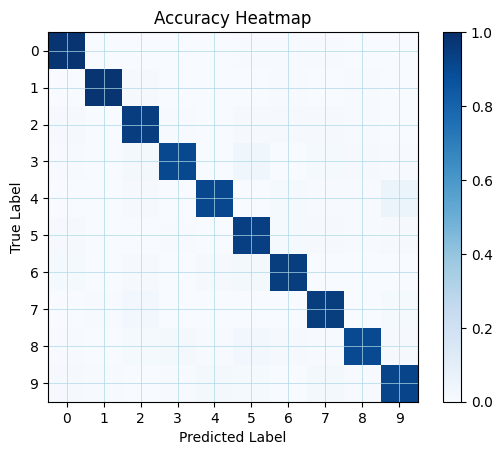

In [ ]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

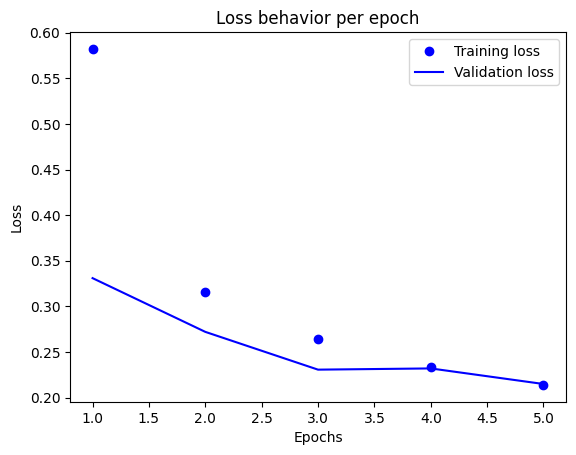

In [ ]:
plot_loss_per_epoch(fit_history)

## Algoritmo de aprendizagem

De modo padrão vinhamos utilizando o SGD como algoritmo de aprendizagem desde o princípio. Aqui iremos abordar outras alternativas para fins de comparação e ver se estamos no caminho certo ou é melhor redefinir este hiperparâmetro.

De modo geral, notamos que os algoritmos adaptativos, como Adam e RMSPROP não possuem uma convergência tão clara como o SGD, basta olhar o gráfico da evolução do treino em comparação com a validação, no entanto a variação dos resultados está acontecendo num limiar abaixo do SGD que gira em torno de `0.25`. Claro que a performance destes algoritmos pode estar sendo afetada por fatores como o tipo do problema em questão ou outros hiperparâmetros, já que os algoritmos adaptativos se ajustam melhor a certos tipos de problemas e arquiteturas de rede.

Mesmo sendo semelhantes, o Adam performou melhor, obtendo resultados finais superiores àqueles obtidos com o SGD, enquanto o RMSPROP ainda é inferior ao SGD. Aqui vale ainda notar que não variamos o `learning_rate` ainda, mas talvez isso já indique que será um bom caminho, já que um algoritmo com `learning_rate` adaptativo trouxe resultados finais melhores.

### RMSPROP

In [362]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(250, activation='relu'),
    Dense(125, activation='relu'),
    Dense(10, activation='softmax')
])

In [363]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 24s 5ms/step - loss: 0.2240 - accuracy: 0.9366 - val_loss: 0.1417 - val_accuracy: 0.9633
Epoch 2/5
4800/4800 [==============================] - 25s 5ms/step - loss: 0.1205 - accuracy: 0.9703 - val_loss: 0.1310 - val_accuracy: 0.9702
Epoch 3/5
4800/4800 [==============================] - 24s 5ms/step - loss: 0.1012 - accuracy: 0.9766 - val_loss: 0.1638 - val_accuracy: 0.9709
Epoch 4/5
4800/4800 [==============================] - 23s 5ms/step - loss: 0.0857 - accuracy: 0.9814 - val_loss: 0.1909 - val_accuracy: 0.9669
Epoch 5/5
4800/4800 [==============================] - 23s 5ms/step - loss: 0.0772 - accuracy: 0.9838 - val_loss: 0.1646 - val_accuracy: 0.9746


In [364]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.1388 - accuracy: 0.9755 - 688ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


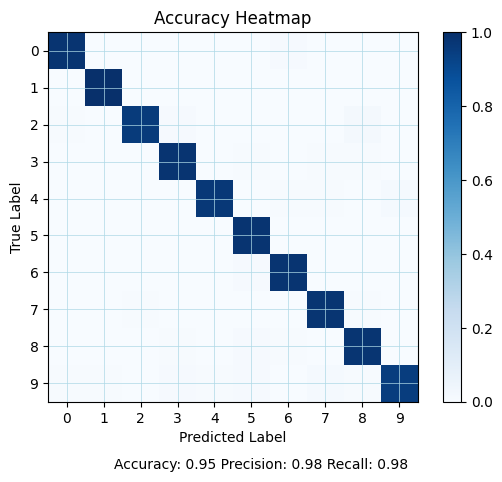

In [365]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

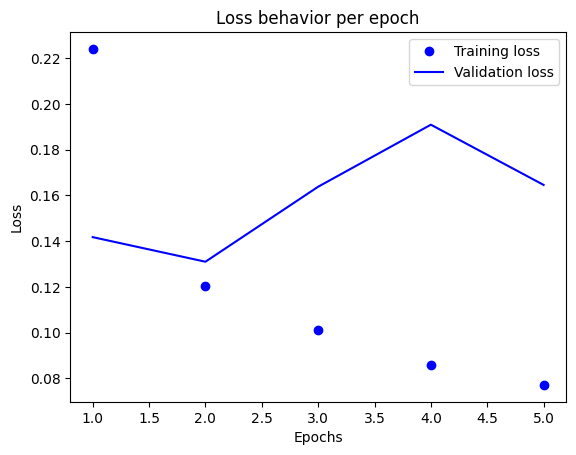

In [366]:
plot_loss_per_epoch(fit_history)

### Adam

In [367]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(250, activation='relu'),
    Dense(125, activation='relu'),
    Dense(10, activation='softmax')
])

In [368]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fit_history = model.fit(x_train, y_train, epochs=5, batch_size=10, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 27s 5ms/step - loss: 0.2109 - accuracy: 0.9373 - val_loss: 0.1263 - val_accuracy: 0.9638
Epoch 2/5
4800/4800 [==============================] - 30s 6ms/step - loss: 0.0954 - accuracy: 0.9707 - val_loss: 0.1020 - val_accuracy: 0.9715
Epoch 3/5
4800/4800 [==============================] - 26s 5ms/step - loss: 0.0716 - accuracy: 0.9780 - val_loss: 0.1014 - val_accuracy: 0.9691
Epoch 4/5
4800/4800 [==============================] - 28s 6ms/step - loss: 0.0519 - accuracy: 0.9841 - val_loss: 0.0963 - val_accuracy: 0.9752
Epoch 5/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.0433 - accuracy: 0.9862 - val_loss: 0.1252 - val_accuracy: 0.9716


In [369]:
metrics = get_metrics(x_test, y_test, model)

313/313 - 1s - loss: 0.1024 - accuracy: 0.9753 - 774ms/epoch - 2ms/step
313/313 [==============================] - 1s 2ms/step


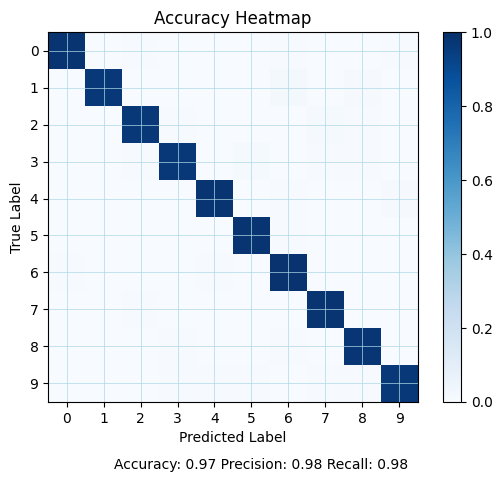

In [370]:
macros = metrics['macro']
plot_accuracy_per_label(y_test, metrics['y_pred_labels'], accuracy=macros['accuracy'], precision=macros['precision'], recall=macros['recall'])

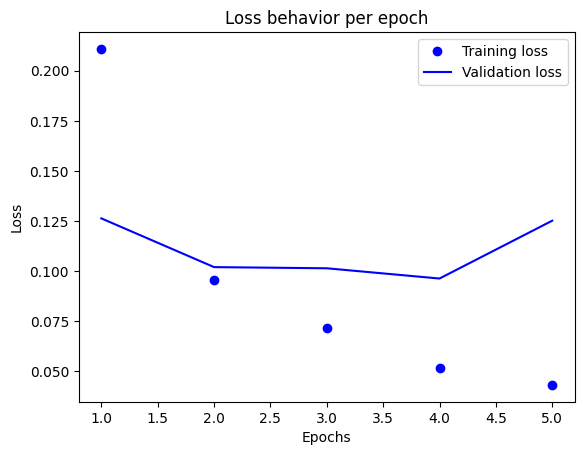

In [371]:
plot_loss_per_epoch(fit_history)